Author - Andrew W. Jackura

Email - ajackura@odu.edu / ajackura@jlab.org

# Two Particles in a Box

Since Lattice QCD in a numerical tool and modern computer only have so many resources we must necessailry truncate space-time. As it turns out this truncation has an interesting effect of multi-hadron systems and thus we must study finite-volume physics to get a better understanding of what these effects are. As a stepping stone to this, here we begin by studying two non-interacting particles in box.

Let us now consider the same system in a finite-volume where we are imagining the two particles in a box of length $L$ with periodic boundary conditions. To see how this changes things lets first consider what happens when we put just a single particle inside the box. Since its just a single particle with no interactions it should behave as a plane wave, $\phi_{\vec{p}}(\vec{x})=e^{i\vec{p}\cdot\vec{x}}$. If we now apply the fact that we have periodic boundary conditions, then we find

$$
\phi_{\vec{p}}(\vec{x}) = \phi_{\vec{p}}(\vec{x}+L\vec{n})
\implies e^{i\vec{p}\cdot\vec{x}} = e^{i\vec{p}\cdot\vec{x} + i\vec{p}\cdot\vec{n}L}
$$

where $\vec{n}=[n_{x},n_{y},n_{z}]$ and $n_{x}$, $n_{y}$, and $n_{z}$ are integers. For this to be true the momentum must be

$$
\vec{p} = \frac{2\pi\vec{n}}{L}.
$$

In [3]:
'''
Importing useful libraries
'''
import cmath as cm                          # math library (complex)
import math as m                            # math library
import numpy as np                          # basic functions, linear algebra, etc.
import scipy.special as sp                  # special functions
import numpy.random as rn                   # random numbers
import matplotlib.pyplot as plt             # plotting library
import itertools                            # for creating tuple list
from scipy import optimize                  # numerical root finding
from scipy import integrate                 # library for integration
from mpl_toolkits import mplot3d            # for 3d plotting 
from matplotlib.colors import hsv_to_rgb    # convert the color from HSV coordinates to RGB coordinates
from colorsys import hls_to_rgb             # convert the color from HLS coordinates to RGB coordinates    

## Free Two-particle Spectrum

The total energy of a two particle system in a box moving with momentum $\mathbf{P}$ is given by the usual energy dispersion relation
$$
E = \sqrt{m^2 + \mathbf{p}^2} + \sqrt{m^2 + (\mathbf{P}-\mathbf{p})^2} \, ,
$$
where $m$ is the mass of the individual particles, $mathbf{p}$ is the momentum of particle 1, and $\mathbf{P}-\mathbf{p}$ is the momentum of particle 2. Recall from scattering theory that the total center-of-momentum (CM) frame energy $E^{\star}$ is defined as
$$
s = E^{\star\,2} = E^2 - \mathbf{P}^2 \, ,
$$
where $s$ is the Mandelstam invariant.

In a finite volume, all free momenta are quantized, $\mathbf{p} = 2\pi \mathbf{n} / L$ and $\mathbf{P} = 2\pi \mathbf{n}_P / L$ where $\mathbf{n},\mathbf{n}_P \in \mathbb{Z}^3$. Substituting these into the dispersion relation we get
$$
\frac{E}{m} = \sqrt{1 + \left(\frac{2\pi}{mL} \right)^2 \mathbf{n}^2} + \sqrt{1 + \left(\frac{2\pi}{mL} \right)^2(\mathbf{n}_P-\mathbf{n})^2} \, ,
$$
with the CM frame energy being 
$$
\left(\frac{E^{\star}}{m}\right)^{2} = \left(\frac{E}{m}\right)^2 - \left(\frac{2\pi}{mL} \right)^2 \mathbf{n}_P^2 \, ,
$$
where we have expressed the energies in units of the particle mass.

It is useful to express our quantities in terms of a dimensionless mass 
$$
\bar{m} \equiv \frac{mL}{2\pi}\, 
$$
Then, the dispersion relation is simply $E / m = \sqrt{1 + \mathbf{n}^2 / \bar{m}^2} + \sqrt{1+ (\mathbf{P}-\mathbf{p})^2/ \bar{m}^2}$. Other dimensionless *barred* variables can be defined similarly, e.g. $\bar{E} = EL / 2\pi$. Note that this allows such conversions $E/m = \bar{E}/\bar{m}$.

### Exercise:

1. Plot the non-interacting spectrum in terms of $E^{\star}/m$ in the rest frame $\mathbf{n}_P = [000]$ as a function of $mL$.

2. Repeat (1) for the frames $\mathbf{n}_P = [000], [001], [011], [111], [002]$.


In [4]:
twoPi = 2.0 * np.pi

def free_spectrum( m1_sq, m2_sq, n, nP ):
    energy1 = np.sqrt( m1_sq + np.inner(n,n) )
    energy2 = np.sqrt( m2_sq + np.inner(nP-n,nP-n) )
    return energy1 + energy2

def generate_free_spectrum( mL, mRatio, nP, EcmMax ):
    m1 = mL / twoPi
    m2 = m1 * mRatio
    m1_sq = m1**2
    m2_sq = m2**2
    nMax = 3
    Energies = []
    intList = np.array(np.arange(-nMax,nMax+1))
    for i in itertools.product(intList,intList,intList):
        n = np.array(i)
        En = free_spectrum(m1_sq, m2_sq, n, nP)
        Ecm = np.sqrt( En**2 - np.dot(nP,nP) )
        Ecm = 2.0 * m.pi * Ecm / mL
        Ecm = np.round( Ecm, 10 )
        if Ecm not in Energies:
            if Ecm < EcmMax:
                Energies.append(Ecm)
    Energies.sort()
    return Energies

def get_spectrum_data(nP,mRatio,EcmMax,LRange):
    data=[]
    maxLevel = 0
    for mL in LRange:
        Ecm = generate_free_spectrum( mL, mRatio, nP, EcmMax )
        if len(Ecm) > maxLevel:
            maxLevel = len(Ecm)
        data.append(Ecm)

    level = 0
    L_start = 0
    levelData = []
    returnData = []
    for _ in range(maxLevel):
        for i in data:
            if len(i) >= level+1:
                levelData.append(i[level])
            else:
                L_start += 1
        returnData.append([L_list[L_start:],levelData.copy()])
        level += 1
        L_start = 0
        levelData.clear()

    return returnData

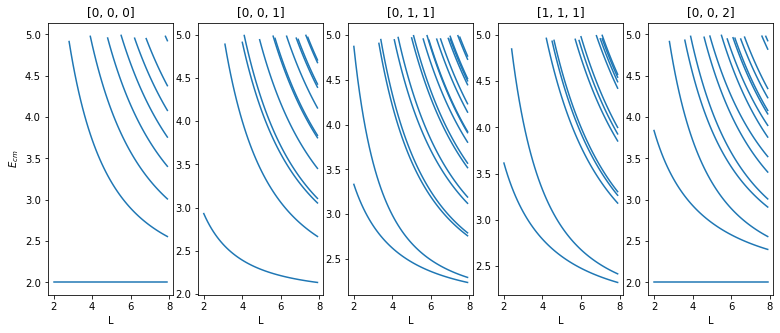

In [10]:
nPList = [[0,0,0],[0,0,1],[0,1,1],[1,1,1],[0,0,2]]
Lmin = 2.0
Lmax = 8.0
Lstep = 0.1
L_list = np.arange(Lmin,Lmax,Lstep)
mRatio = 1.0
Ecm_o_m_Max = 5.0

fig = plt.figure(figsize=(13,5))

for i,nP in enumerate(nPList):
    tmp = get_spectrum_data(nP,mRatio,Ecm_o_m_Max,L_list)
    plot = fig.add_subplot(1,len(nPList),i+1)
    plot.set_title(str(nP))
    plot.set_xlabel("L")
    if i == 0:
        plot.set_ylabel(r'$E_{cm}$')
    for j in tmp:
        plot.plot(j[0],j[1],color="tab:blue")

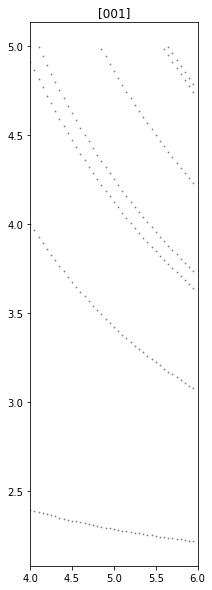

In [6]:
nP = np.array([0,0,1])
Ecm_o_m_Max = 5.0
mRatio = 1.0
Ecm = []
for mL in np.arange (4.0, 6.0, 0.05):
   Ecm.append( generate_free_spectrum( mL, mRatio, nP, Ecm_o_m_Max ) )
   #print( round(mL,6), " ", *Ecm )
mL = np.arange(4.0, 6.0, 0.05)
#Ecm = np.asarray(Ecm)
#Ecm.shape
#mL.shape
#Ecm[45]


plt.figure(figsize=(3,10))
plt.xlim([4, 6])
plt.title("[001]")
for xe, ye in zip(mL, Ecm):
    plt.scatter([xe] * len(ye), ye, s = 0.6, c = "gray")
    


#for Estar in Ecm.reshape(1,len(Ecm)).T:
   # print(Estar)

#plt.plot( mL, Ecm[:] )